In [1]:
import pooch

url = "https://github.com/LaPoGeoMar/Proj_Modelagem_Pellet/releases/download"
version = "v0.1.0"

fname = pooch.retrieve(
    url=f"{url}/{version}/model_tides_only.nc4",
    known_hash="sha256:b6941a8e4cf158790d899e00e644d6c6a6dcaf28128623467699e5a3b23417cd",
)

In [2]:
import xarray as xr

ds = xr.open_dataset(fname)

In [3]:
# adp location
lon, lat = -48.401215, -27.253183

In [4]:
import numpy as np


def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx


m = find_nearest(ds["m"], lon)
n = find_nearest(ds["n"], lat)
serie = ds.isel(m=m, n=n)

In [5]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from cartopy.mpl.gridliner import LATITUDE_FORMATTER, LONGITUDE_FORMATTER


def creat_map(projection=ccrs.PlateCarree(), figsize=(4, 4), bbox=None):
    fig, ax = plt.subplots(
        figsize=figsize,
        subplot_kw={
            "projection": projection,
        },
    )
    if bbox:
        ax.set_extent(bbox)
    gl = ax.gridlines(draw_labels=True)
    gl.top_labels = gl.right_labels = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    ax.coastlines(resolution="10m")
    return fig, ax

In [6]:
bbox = ds["m"].min(), ds["m"].max(), ds["n"].min(), ds["n"].max()
bbox = [v.to_numpy() for v in bbox]

x, y = np.meshgrid(ds["m"], ds["n"])

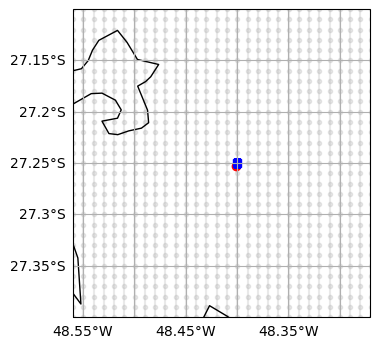

In [7]:
# %matplotlib notebook

fig, ax = creat_map(bbox=bbox)

kw = {"marker": ".", "linestyle": "-", "alpha": 0.25, "color": "darkgray"}
ax.plot(x, y, **kw, zorder=0)
ax.plot(lon, lat, "ro")
ax.plot(serie["longitude"], serie["latitude"], "bs")

ax.set_extent([-48.56, -48.27, -27.4, -27.1])

In [8]:
import utide

time = serie["time"].to_numpy()
u, v = serie["velocity_x"].to_numpy(), serie["velocity_y"].to_numpy()


coef = utide.solve(
    time,
    u,
    v,
    lat=-27.253183,
    method="robust",
    conf_int="MC",
    verbose=False,
)

/home/filipe/micromamba/envs/PARCELS/lib/python3.11/site-packages/utide/harmonics.py:16: RuntimeWarning: invalid value encountered in cast
  nshallow = np.ma.masked_invalid(const.nshallow).astype(int)
/home/filipe/micromamba/envs/PARCELS/lib/python3.11/site-packages/utide/harmonics.py:17: RuntimeWarning: invalid value encountered in cast
  ishallow = np.ma.masked_invalid(const.ishallow).astype(int) - 1


In [9]:
import pandas as pd


def make_table_uv(coef):
    summary = pd.DataFrame(coef["diagn"])
    summary["frq"] = coef["aux"]["frq"]
    summary["Lsmaj"] = coef["Lsmaj"]
    summary["Lsmaj_ci"] = coef["Lsmaj_ci"]
    summary["Lsmin"] = coef["Lsmin"]
    summary["Lsmin_ci"] = coef["Lsmin_ci"]
    summary["theta"] = coef["theta"]
    summary["theta_ci"] = coef["theta_ci"]
    summary["g"] = coef["g"]
    summary["g_ci"] = coef["g_ci"]
    summary = summary.set_index("name")
    return summary.sort_values(by="Lsmaj", ascending=False)


summary = make_table_uv(coef)

In [10]:
summary.head(10)

,PE,SNR,frq,Lsmaj,Lsmaj_ci,Lsmin,Lsmin_ci,theta,theta_ci,g,g_ci
name,,,,,,,,,,,
M2,60.632271,1.222734e+06,0.080511,0.069692,0.000087,0.021434,0.000096,140.573193,0.083197,62.823983,0.097190
S2,24.185990,5.109105e+05,0.083333,0.044626,0.000088,0.011366,0.000090,146.332999,0.128533,71.745552,0.144823
O1,6.705376,5.117222e+04,0.038731,0.021631,0.000135,0.010956,0.000161,144.153810,0.737877,19.519847,0.495905
M4,2.616083,1.026529e+05,0.161023,0.014854,0.000078,-0.002954,0.000050,130.826452,0.188971,218.106792,0.346595
K2,2.382243,4.529875e+04,0.083561,0.014175,0.000088,0.002818,0.000100,144.848744,0.356619,69.152745,0.422717
K1,1.139734,7.205516e+03,0.041781,0.009789,0.000105,0.002027,0.000206,156.128639,1.099755,107.464902,0.732863
N2,1.242310,1.871727e+04,0.078999,0.009287,0.000098,0.004762,0.000113,155.889865,1.102604,134.740474,0.990831
Q1,0.415822,2.161302e+03,0.037219,0.005100,0.000106,0.003233,0.000232,149.800387,3.992542,345.656387,3.173581
MS4,0.248979,1.094404e+04,0.163845,0.004451,0.000070,-0.001422,0.000052,157.467189,0.751178,297.875423,1.002052


In [11]:
from utide import reconstruct

tide = reconstruct(time, coef)

prep/calcs ... done.


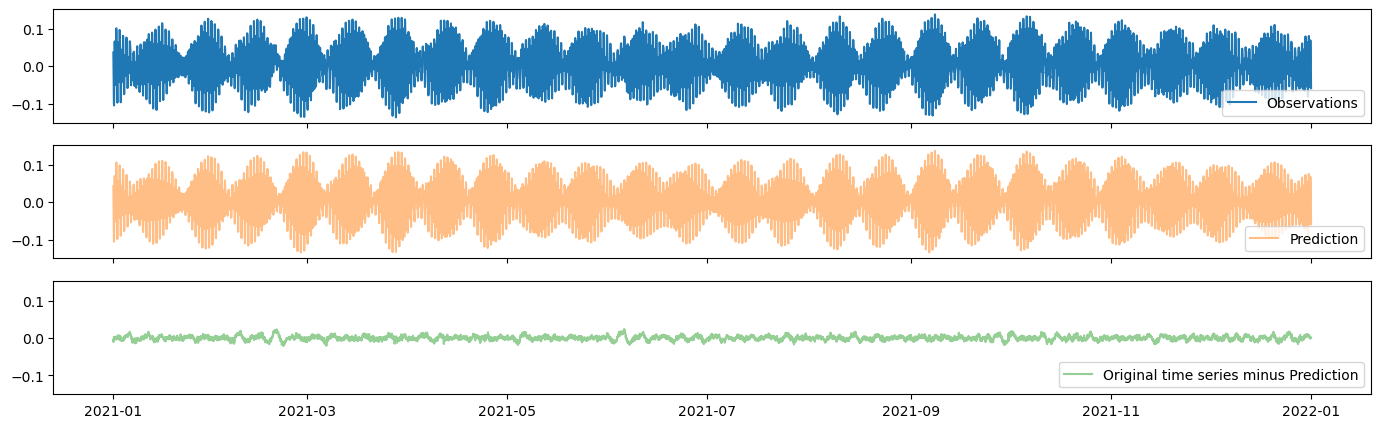

In [12]:
fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, sharey=True, sharex=True, figsize=(17, 5))

ax0.plot(time, u, label="Observations", color="C0")
ax0.legend(numpoints=1, loc="lower right")

ax1.plot(time, tide["u"], alpha=0.5, label="Prediction", color="C1")
ax1.legend(numpoints=1, loc="lower right")

ax2.plot(
    time,
    u - tide["u"],
    alpha=0.5,
    label="Original time series minus Prediction",
    color="C2",
)
ax2.legend(numpoints=1, loc="lower right");

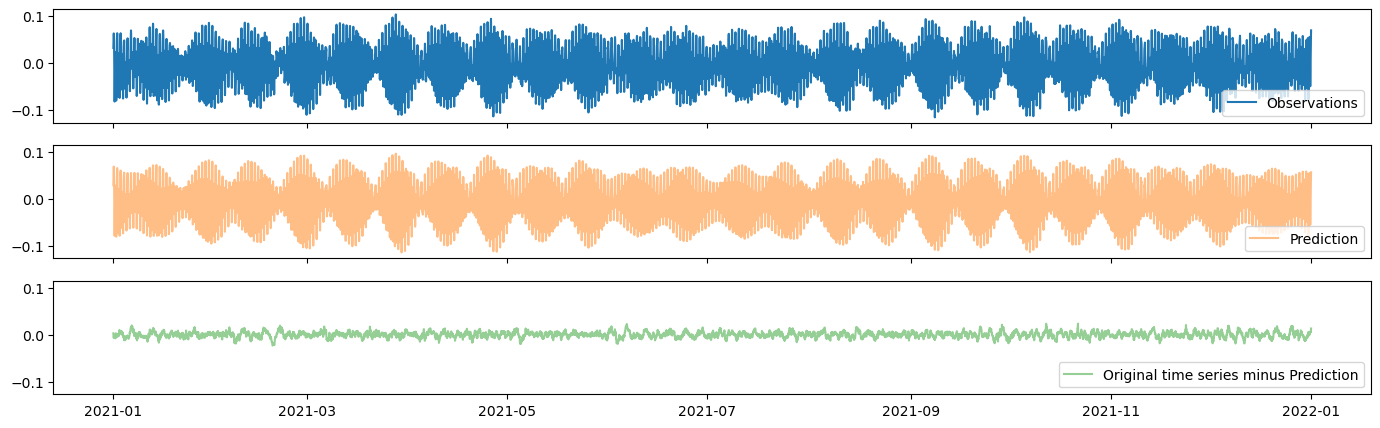

In [13]:
fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, sharey=True, sharex=True, figsize=(17, 5))

ax0.plot(time, v, label="Observations", color="C0")
ax0.legend(numpoints=1, loc="lower right")

ax1.plot(time, tide["v"], alpha=0.5, label="Prediction", color="C1")
ax1.legend(numpoints=1, loc="lower right")

ax2.plot(
    time,
    v - tide["v"],
    alpha=0.5,
    label="Original time series minus Prediction",
    color="C2",
)
ax2.legend(numpoints=1, loc="lower right");

In [14]:
import tidal_ellipse


def plot_ellipse(comp):
    const = summary.loc[comp]

    SEMA, SEMI = const["Lsmaj"], const["Lsmin"]
    PHA, INC = const["g"], const["theta"]
    ECC = SEMI / SEMA

    tidal_ellipse.do_the_plot(SEMA, ECC, INC, PHA)

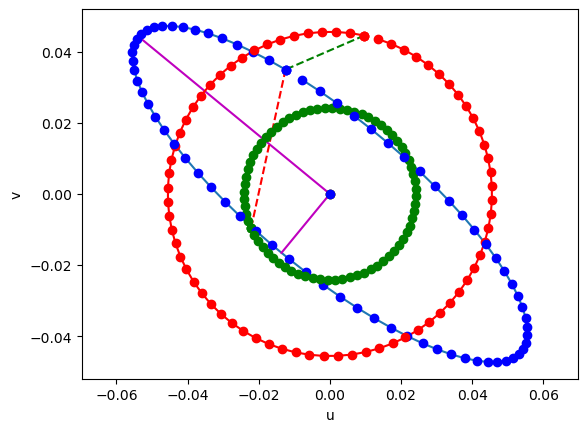

In [15]:
plot_ellipse("M2")

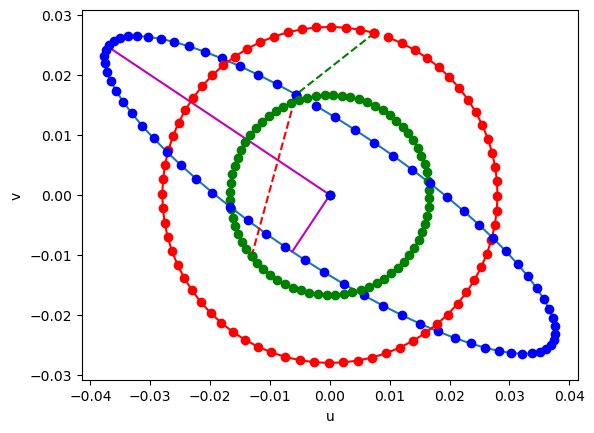

In [16]:
plot_ellipse("S2")

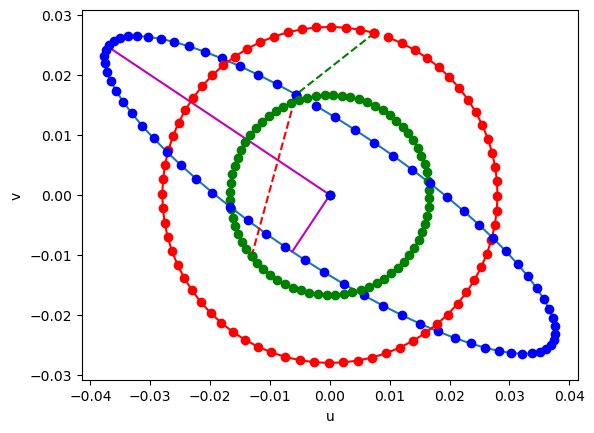

In [17]:
plot_ellipse("S2")

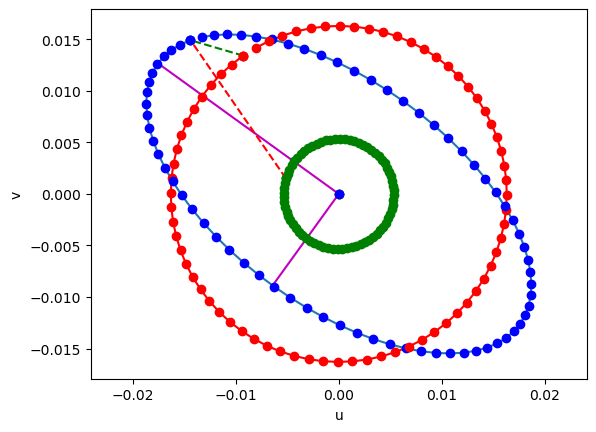

In [18]:
plot_ellipse("O1")

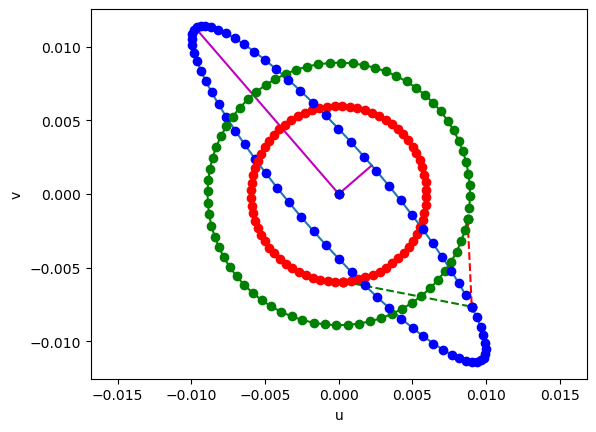

In [19]:
plot_ellipse("M4")

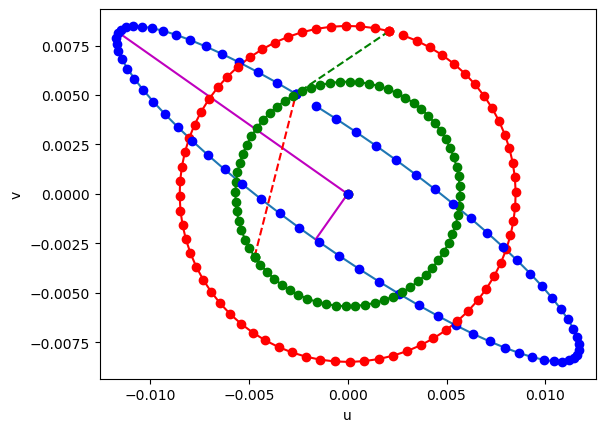

In [20]:
plot_ellipse("K2")

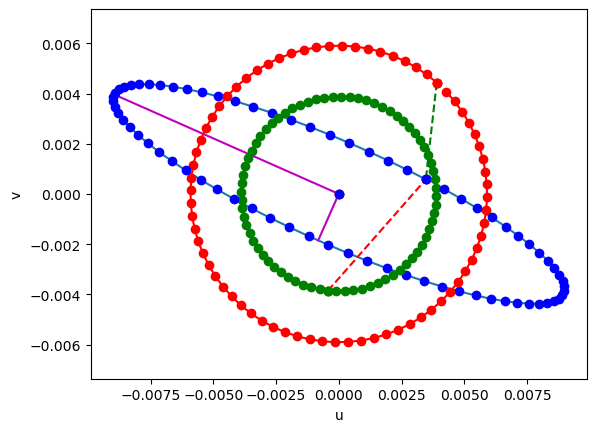

In [21]:
plot_ellipse("K1")

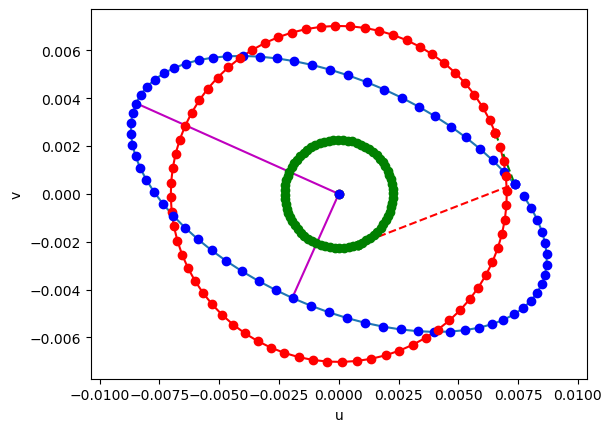

In [22]:
plot_ellipse("N2")

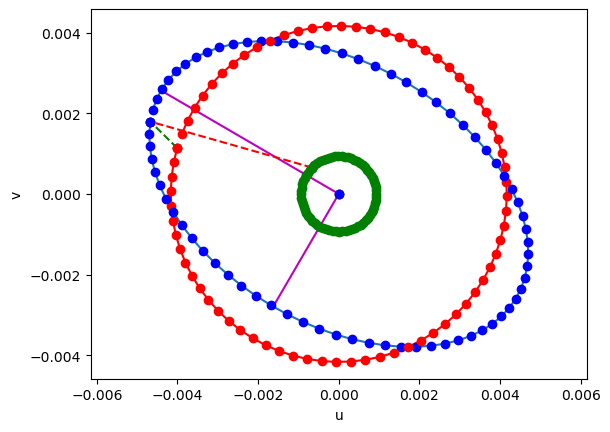

In [23]:
plot_ellipse("Q1")